In [34]:
from numpy.random import seed
seed(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis import *
from collections import namedtuple
import Metrics
from PatientSet import PatientSet
from Constants import Constants
from Clustering import *
import re

#sklearn dependencies
from sklearn.metrics import roc_auc_score, adjusted_rand_score
from sklearn.utils import resample
from sklearn.cluster import FeatureAgglomeration

#we get like a million deprication errors for some reason with the external libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#plotting parameter
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
FIG_SIZE = (20,15)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=FIG_SIZE)

In [35]:
#load in the patientset object that has all the patient info
db = PatientSet()

#add a bunch of features to the object that we'll want to try
#so we can use the db.to_dataframe function to get them all in a nice dataframe with one-hot encoding and labels automatically
db.t_volumes = np.array([np.sum([g.volume for g in gtvs]) for gtvs in db.gtvs]).reshape(-1,1)
db.bilateral = db.lateralities == 'B'
db.total_volumes = db.volumes.sum(axis = 1)
db.toxicity = db.feeding_tubes + db.aspiration > 0
db.tsimdoses = tsim_prediction(db)
db.neck_width = np.linalg.norm(db.centroids[:,Constants.organ_list.index('Lt_Sternocleidomastoid_M'),:] - db.centroids[:,Constants.organ_list.index('Rt_Sternocleidomastoid_M'), :], axis = 1)

/media/andrew/DATA/git_repos/CAMP-RT/PYTHON/Patient.py:360: RuntimeWarning: invalid value encountered in true_divide
  mean_tumor_distances /= tumor_volume
/media/andrew/DATA/git_repos/CAMP-RT/PYTHON/Patient.py:361: RuntimeWarning: invalid value encountered in true_divide
  tumor_position /= tumor_volume


error reading tumor volume for  10091
error reading tumor volume for  10148

patient data loaded...



In [79]:
%load_ext autoreload
%autoreload 2
from Clustering import *

#parameters for the experiments
toxicities_to_test = ['toxicity']

#features to test the feature selection on.  should be fields in the patientset we have
#we don't cluster on these
unclusterable_features = ['t_volumes', 'bilateral', 'total_volumes','neck_width']
#we cluster on these (each individually) if feature_clustering is defined,
clusterable_features = ['tumor_distances', 'volumes']

#features specifically for feature selection vs actually using.  Should either be
#some combo of actual and predicted dose for this
true_features = ['doses']
predicted_features = ['tsimdoses']

#number of times to resample and doing feature selection
#if n = 1, just use the first result
n_samples = 300

df_rescale = Metrics.normalize

#put some bounds on the features to subset
min_features = 2

#for now just constrain it to one cluster
n_clusters = 2
selection_clusterer  = FClusterer(n_clusters)
cluster_feature_selector = FeatureClusterSelector(
    n_samples = n_samples,
    clusterer = selection_clusterer)
lg_feature_selector = FeatureSelector(n_samples = n_samples)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
true, predicted = get_train_test_datasets(db, 
                                      unclusterable_features, 
                                      clusterable_features, 
                                      true_features, 
                                      predicted_features)
if df_rescale is not None:
    true = df_rescale(true)
    predicted = df_rescale(predicted)

TypeError: 'module' object is not callable

In [81]:
cluster_importances = cluster_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
cluster_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,3.000000e+02,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02
mean,5.110384e-01,0.684421,0.936289,0.894204,0.954073,0.861343,0.683484,0.963443,0.967159,0.952756,...,0.609048,0.600091,0.835331,0.570026,0.443703,0.829955,0.213672,0.873802,0.650630,2.047147e-01
std,3.610987e-01,0.357880,0.177406,0.210060,0.123453,0.251284,0.388151,0.100784,0.130423,0.122761,...,0.363377,0.323347,0.257154,0.417552,0.405908,0.242607,0.349668,0.207341,0.370688,3.684704e-01
min,-2.220446e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.134588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.271056e-01,0.454585,0.974298,0.850000,0.965540,0.863811,0.373259,0.982991,0.994499,0.977777,...,0.332442,0.364034,0.815382,0.000000,0.000000,0.799400,0.000000,0.853843,0.510214,0.000000e+00
50%,5.334403e-01,0.861907,0.998092,0.995529,0.997907,0.990476,0.892149,0.998339,0.999761,0.997876,...,0.763526,0.651555,0.962303,0.815000,0.436789,0.934243,0.000000,0.976194,0.819131,0.000000e+00
75%,8.630965e-01,0.991984,0.999943,0.999959,0.999918,0.999722,0.998867,0.999927,0.999997,0.999852,...,0.923869,0.901523,0.993568,0.908007,0.867785,0.990982,0.380972,0.998348,0.947217,1.110223e-16
max,9.999999e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999984,0.999703,1.000000,0.999191,1.000000,1.000000,0.999304,1.000000,0.999576,9.999974e-01


In [82]:
lg_importances = lg_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
lg_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.563925,0.705467,0.691912,0.696389,0.678862,0.720105,0.629910,0.682196,0.672819,0.691772,...,0.509148,0.437397,0.631523,0.283591,0.555247,0.610118,0.542431,0.671273,0.341010,0.570577
std,0.126806,0.078712,0.068103,0.069667,0.061447,0.051420,0.067060,0.062094,0.064437,0.055162,...,0.137641,0.161468,0.075927,0.150764,0.114429,0.073381,0.101785,0.056981,0.209695,0.182832
min,0.000000,0.117110,0.270005,0.215932,0.473143,0.548336,0.387000,0.498945,0.466518,0.540923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.179429,0.000000,0.499153,0.000000,0.000000
25%,0.525299,0.671029,0.651503,0.654517,0.636676,0.683905,0.587304,0.639776,0.627132,0.657288,...,0.475984,0.394886,0.598712,0.180689,0.509036,0.568526,0.504582,0.636202,0.195234,0.550251
50%,0.590215,0.713852,0.695309,0.700764,0.677902,0.721968,0.638449,0.689089,0.679638,0.698934,...,0.546233,0.486063,0.637511,0.267879,0.578988,0.620792,0.556534,0.675880,0.313148,0.625798
75%,0.636646,0.755088,0.739817,0.743999,0.723145,0.755091,0.675305,0.726365,0.720257,0.733500,...,0.591464,0.536291,0.676290,0.388364,0.626375,0.659106,0.599643,0.710469,0.545630,0.680854
max,0.757286,0.849144,0.829576,0.830681,0.822353,0.849460,0.798788,0.849371,0.842057,0.821598,...,0.740027,0.712798,0.820513,0.645161,0.753600,0.770196,0.710397,0.806944,0.727364,0.790823


In [83]:

top_n_importances = lambda x, n: x.mean().sort_values(ascending = False).iloc[0:n]
def plot_n_importances(x, n):
    x = x.reindex(x.mean().sort_values(ascending=False).index, axis = 'columns')
    x = x.iloc[:,0:n]
    xrange = [x.mean().values.min()*.99, x.mean().values.max()*1.01]
    x.mean().plot.barh(**{'xerr': x.std().values/np.sqrt(n_samples), 'xlim': xrange})

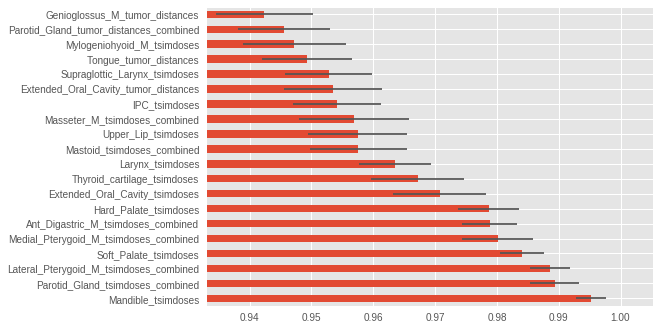

In [84]:
plot_n_importances(cluster_importances, 20)
plt.savefig('cluster_importances_n=1000.png',bbox_inces='tight')

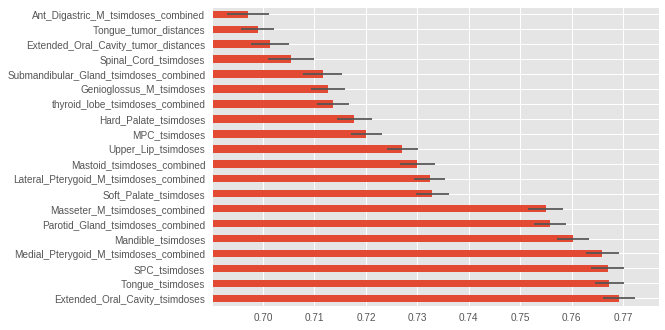

In [85]:
plot_n_importances(lg_importances,20)

In [86]:
true_cluster_importances = cluster_importances = cluster_feature_selector.get_importances(true, db.toxicity, as_df = True)
true_cluster_importances.describe()

,Esophagus_doses,Spinal_Cord_doses,Cricopharyngeal_Muscle_doses,Cricoid_cartilage_doses,IPC_doses,MPC_doses,Brainstem_doses,Larynx_doses,Thyroid_cartilage_doses,Supraglottic_Larynx_doses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,3.000000e+02,3.000000e+02,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02
mean,0.568233,0.539569,0.747161,0.793004,0.879830,0.838958,0.812846,0.851243,0.863805,0.789294,...,0.623564,0.559747,8.283202e-01,5.461360e-01,0.406960,0.836405,0.188362,0.885960,0.619845,2.356744e-01
std,0.336059,0.340423,0.310701,0.287409,0.218953,0.290600,0.264411,0.259735,0.240269,0.397499,...,0.340804,0.343038,2.480554e-01,4.181836e-01,0.411346,0.244599,0.333750,0.216877,0.371416,3.786231e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-2.220446e-16,-2.220446e-16,0.000000,0.000000,0.000000,0.000000,0.000000,-2.220446e-16
25%,0.299206,0.199490,0.563938,0.691466,0.877243,0.864924,0.787164,0.836014,0.862451,0.952854,...,0.341094,0.276981,7.589723e-01,0.000000e+00,0.000000,0.820000,0.000000,0.886694,0.436659,0.000000e+00
50%,0.619019,0.574606,0.902979,0.946952,0.973475,0.956566,0.924211,0.981649,0.974376,0.998521,...,0.741605,0.643458,9.479396e-01,7.950000e-01,0.325589,0.945450,0.000000,0.980930,0.776935,0.000000e+00
75%,0.882879,0.864592,0.993428,0.995679,0.998097,0.994902,0.991813,0.998655,0.997151,0.999938,...,0.913753,0.864955,9.954584e-01,8.904665e-01,0.863762,0.991991,0.304443,0.998589,0.923363,5.859906e-01
max,1.000000,0.998999,0.999999,0.999999,1.000000,0.999998,0.999998,1.000000,1.000000,1.000000,...,0.999862,0.999842,1.000000e+00,9.987284e-01,0.999993,1.000000,0.999962,1.000000,0.999883,9.999738e-01


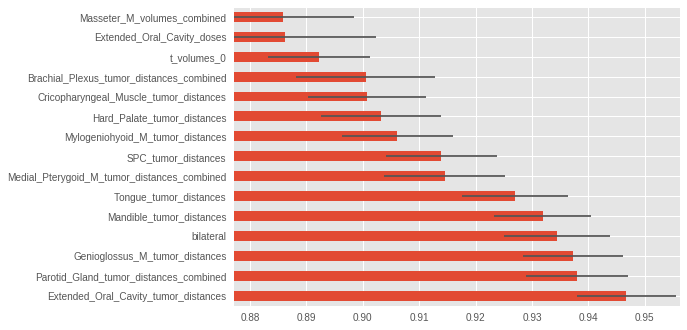

In [87]:
plot_n_importances(true_cluster_importances, 15)

In [88]:
true_lg_importances8 = lg_feature_selector.get_importances(true, db.toxicity, as_df = True)
true_lg_importances.describe()

,Esophagus_doses,Spinal_Cord_doses,Cricopharyngeal_Muscle_doses,Cricoid_cartilage_doses,IPC_doses,MPC_doses,Brainstem_doses,Larynx_doses,Thyroid_cartilage_doses,Supraglottic_Larynx_doses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.497272,0.399417,0.498953,0.487815,0.665793,0.667674,0.539446,0.617995,0.617892,0.707711,...,0.502409,0.432141,0.626987,0.283521,0.548482,0.611950,0.545907,0.666313,0.344430,0.594392
std,0.121248,0.163504,0.122853,0.124386,0.056018,0.054389,0.105961,0.071348,0.067822,0.045805,...,0.138362,0.162036,0.073579,0.149311,0.126401,0.075013,0.101719,0.059627,0.206027,0.157114
min,0.000000,0.000000,0.000000,0.000000,0.389653,0.458675,0.000000,0.039548,0.216944,0.535781,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.448055,0.000000,0.000000
25%,0.452885,0.340400,0.461921,0.456052,0.630468,0.631683,0.499978,0.583456,0.580205,0.678278,...,0.474718,0.382503,0.590510,0.169134,0.517622,0.579193,0.504722,0.628534,0.186584,0.570644
50%,0.517820,0.450462,0.520785,0.513607,0.669864,0.667648,0.552760,0.624812,0.621816,0.710042,...,0.535345,0.480683,0.633908,0.275015,0.576909,0.617804,0.562579,0.666434,0.322871,0.634588
75%,0.574531,0.511452,0.572963,0.562578,0.704790,0.707267,0.602508,0.663633,0.664152,0.740227,...,0.585892,0.538897,0.674030,0.394587,0.621585,0.657868,0.609898,0.706590,0.543784,0.682931
max,0.753249,0.658431,0.746320,0.725115,0.809244,0.817275,0.769712,0.807824,0.781126,0.841931,...,0.738064,0.724460,0.802745,0.651665,0.753078,0.820963,0.763381,0.833254,0.762195,0.828052


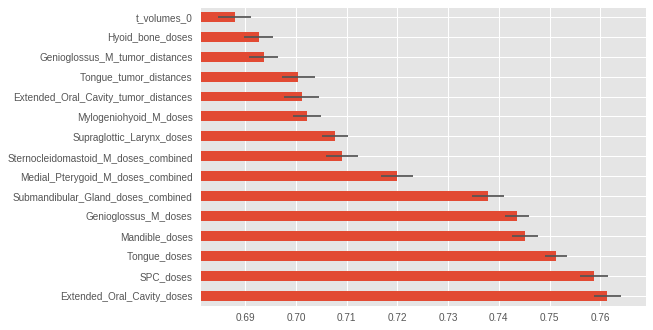

In [89]:
plot_n_importances(true_lg_importances, 15)

In [90]:
cluster_importances

,Esophagus_doses,Spinal_Cord_doses,Cricopharyngeal_Muscle_doses,Cricoid_cartilage_doses,IPC_doses,MPC_doses,Brainstem_doses,Larynx_doses,Thyroid_cartilage_doses,Supraglottic_Larynx_doses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
0,3.016991e-01,9.514491e-01,0.592369,0.705509,0.169360,0.952227,5.670547e-01,9.993642e-01,0.933320,0.000000e+00,...,5.944414e-01,0.000000e+00,0.810000,8.100000e-01,0.000000e+00,0.840000,0.000000e+00,0.637833,0.840000,8.400000e-01
1,3.869598e-01,9.746995e-01,0.993296,0.999972,0.997881,0.423450,8.775544e-01,3.540558e-01,0.997726,9.999387e-01,...,9.130575e-01,7.353494e-01,0.840000,8.400000e-01,0.000000e+00,0.998993,9.887164e-01,0.999992,0.770000,0.000000e+00
2,1.110223e-16,4.731024e-01,0.672759,0.914174,0.518010,0.990018,9.988363e-01,8.402317e-01,0.384215,9.968080e-01,...,8.500000e-01,0.000000e+00,0.735852,0.000000e+00,0.000000e+00,0.999398,5.076327e-01,0.789687,0.978330,9.983463e-01
3,9.149150e-01,9.712948e-01,0.824584,0.944581,0.992548,0.868758,9.978145e-01,9.978145e-01,0.840919,9.990464e-01,...,3.658220e-01,8.474205e-01,0.926536,0.000000e+00,4.268094e-01,1.000000,0.000000e+00,0.999914,0.000000,0.000000e+00
4,9.838008e-01,3.062178e-01,0.966626,0.300408,0.878252,0.999959,9.961303e-01,9.999517e-01,0.996616,9.996787e-01,...,8.250000e-01,9.794898e-01,0.963261,9.810050e-01,9.045993e-01,0.760000,0.000000e+00,0.999845,0.760000,0.000000e+00
5,6.798786e-01,2.274166e-01,0.984421,0.978555,0.972212,0.990283,9.970775e-01,9.963727e-01,0.999529,9.841175e-01,...,0.000000e+00,9.732228e-01,0.999228,0.000000e+00,0.000000e+00,0.968342,0.000000e+00,0.999996,0.850808,8.508085e-01
6,7.357563e-01,1.434221e-01,0.552505,0.948642,0.997722,0.920409,3.082801e-01,9.745327e-01,0.982485,9.999874e-01,...,3.200172e-01,7.751915e-01,0.914434,0.000000e+00,0.000000e+00,0.989571,0.000000e+00,0.999640,0.679899,6.798995e-01
7,0.000000e+00,8.801650e-01,0.312365,0.284631,0.475112,0.868758,6.312060e-01,8.097071e-01,0.987926,9.996159e-01,...,0.000000e+00,9.286585e-01,0.460245,0.000000e+00,0.000000e+00,1.000000,3.511068e-01,0.999760,0.682013,0.000000e+00
8,9.858035e-01,6.689128e-01,0.947038,0.998129,0.993041,0.999538,6.532704e-01,9.203991e-01,0.595730,9.959313e-01,...,6.910573e-01,0.000000e+00,0.999001,9.839264e-01,1.670934e-01,0.870000,1.110223e-16,0.946055,0.756332,1.110223e-16
9,6.188764e-01,3.066234e-01,0.999873,0.999772,0.997063,0.990292,9.962437e-01,6.906740e-01,0.847854,9.999970e-01,...,7.432095e-01,8.614505e-01,0.463696,6.312756e-01,0.000000e+00,1.000000,0.000000e+00,0.999903,0.856287,0.000000e+00


In [91]:
#load in the selected features from the clustering notebook
selected_features = pd.read_csv('data/clustering_results/metaClusteringBootstrapped300.csv',index_col=0)
cluster_labels = selected_features.cluster_labels
selected_features = selected_features.drop('cluster_labels', axis = 1)
selected_features.head(5)

,Mandible_tsimdoses,Extended_Oral_Cavity_tsimdoses,Tongue_tsimdoses
Dummy.ID,,,
3,-0.456024,-0.539869,-1.180952
4,-0.679145,-0.839970,-0.564527
10,-0.332554,-0.046562,0.321930
11,-1.164121,-1.256158,-1.387832
27,-0.757925,-0.600296,-0.504715


In [92]:
#get the relative loss of accuracy from dropping each of the variables in the selected features
scorer = FeatureClusterSelector(clusterer = copy.copy(selection_clusterer))
scores = {f: [] for f in selected_features.columns}
scores['baseline'] = []
for n in range(n_samples):
    if n_samples > 1:
        xtemp, ytemp = resample(selected_features, db.toxicity)
    else:
        xtemp, ytemp = selected_features, db.toxicity
    base_score = scorer.bootstrap_score(xtemp, ytemp).mean()
    scores['baseline'].append(base_score)
    for feature in  selected_features.columns:
        xtemp = selected_features.drop(feature, axis = 1)
        new_score = scorer.bootstrap_score(xtemp, db.toxicity).mean()
        scores[feature].append(base_score-new_score)
scores = pd.DataFrame(scores)
scores.describe()

TypeError: 'module' object is not callable

In [ ]:
#convert the scores (drop in clustering correlation) to an actual importance
fscores = scores.drop('baseline', axis = 1).apply(lambda x: 1/np.log(np.abs(1/x))*np.sign(x))
yerr = fscores.std()/np.sqrt(n_samples) if n_samples > 1 else np.zeros((fscores.shape[1],))
yrange = [fscores.mean().values.min()*.9, fscores.mean().values.max()*1.1]
(fscores.mean()).plot.bar(rot = 45, **{'ylim': yrange,'yerr': yerr})

In [ ]:
pcounts = np.arange(1, int(selected_features.shape[0]/2))
n_subsamples = selected_features.shape[0]
sensitivity_report = np.zeros((n_subsamples, len(pcounts)))
feature_df = selected_features.copy()
feature_df['toxicity'] = db.toxicity
for p in pcounts:
    for n in range(n_subsamples):
        data_subset = feature_df.sample(n=int(selected_features.shape[0] - p),
                                          replace = False,
                                          random_state = n)
        tox_subset = data_subset['toxicity'].values
        clusters = selection_clusterer.fit_predict(data_subset.drop(['toxicity'],axis=1).values)
        sensitivity_report[n, p] = fisher_exact_test(tox_subset, clusters)
pd.DataFrame(sensitivity_report).describe()

In [ ]:
db.toxicity